### Simple topic modelings - with google news 

In [91]:
import pandas as pd 
import os 
#from utils import Args
import json 
import numpy as np
from sentence_transformers import SentenceTransformer
from topic_model_utils import *
#model_setup,train_topic_model,eval_topic_model,train_and_eval,hyper_param_permutation,Args,pack_update_param

In [92]:
## define some global paths and variables  
LOAD_EMB = True
TUNE = True
res_folder = '/data/chuang/news_scrape/data/news_search_res'
news_output_p = os.path.join(res_folder,'search_results_raw.csv')
emb_path  = os.path.join(res_folder,'sentence_embeddings.npy')
docs_path = os.path.join(res_folder,'docs.npy')
topic_model_out_path = os.path.join(res_folder,'topic_model')

## Evaluate raw data 

In [93]:
## raw data exploration 
df = pd.read_csv(news_output_p)
print(len(docs))
df.head()


16082


,newspaper_name,time_start,time_end,year,month,day,title,link,body_length,text,education,Keep_tag
0,iwnsvg.com,2010-01-01,2010-02-01,2010,1,5,70 patients relocated after fire in St. Vincen...,https://news.google.com/rss/articles/CBMiUWh0d...,404,70 patients relocated after fire in St. Vincen...,1,1
1,iwnsvg.com,2010-01-01,2010-02-01,2010,1,14,SVG 'paid too little attention' to disabled – ...,https://news.google.com/rss/articles/CBMiTGh0d...,444,SVG 'paid too little attention' to disabled – ...,1,1
2,iwnsvg.com,2010-01-01,2010-02-01,2010,1,19,St. Vincent PM unveils EC$913M budget – iWitne...,https://news.google.com/rss/articles/CBMiRmh0d...,978,St. Vincent PM unveils EC$913M budget – iWitne...,1,1
3,iwnsvg.com,2010-01-01,2010-02-01,2010,1,25,Political parties urged to control supporters ...,https://news.google.com/rss/articles/CBMiRWh0d...,696,Political parties urged to control supporters ...,0,0
4,iwnsvg.com,2010-01-01,2010-02-01,2010,1,26,"No tax, no borrowing, less VAT in 2010 budget ...",https://news.google.com/rss/articles/CBMiTmh0d...,1022,"No tax, no borrowing, less VAT in 2010 budget ...",1,1


<AxesSubplot: >

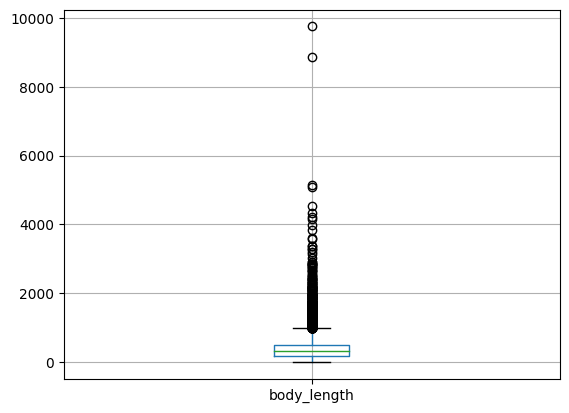

In [94]:
df[['body_length']].boxplot()

In [95]:
## we will filter about 5 % of our data 
low_b = df['body_length'].quantile(0.03)
up_b = df['body_length'].quantile(0.95)
print('lower bound is :{} ; higher bound is : {}'.format(low_b,up_b))
org_len = len(df)
df = df[(df['body_length']>low_b) & (df['body_length']<up_b)]
df = df[df['Keep_tag']==1]
docs = df['text'].tolist() ## get only the body 
print('orignial len: {} ; current len : {}; kept {:.1f}%'.format(org_len,len(docs),len(docs)/org_len*100))

lower bound is :20.0 ; higher bound is : 984.0
orignial len: 17526 ; current len : 3660; kept 20.9%


## Prepare data for topic modeling

In [96]:
## define an arg class to read arguments from json
args = Args('./args/train_args.json')
for attr, value in args.__dict__.items():
    print(f"{attr} = {value}")

verbose = False
model_name = sentence-transformers/all-MiniLM-L6-v2
model_checkpoint = sentence-transformers/all-MiniLM-L6-v2
n_neighbors = 15
n_components = 5
min_cluster_size = 5
min_samples = 5
min_df = 5
nr_topics = auto
metric = euclidean
calculate_probabilities = False
top_n_words = 10


In [97]:
#### load sentence embeding model and encode docs
if not LOAD_EMB:
    print('use model : {}'.format(args.model_name))
    sentence_model = SentenceTransformer(args.model_name)
    embeddings = sentence_model.encode(docs, show_progress_bar=True) ## encode sentences 
    assert len(docs)==len(embeddings)
    embeddings = np.array(embeddings)
    docs = np.array(docs)
    np.save(emb_path,embeddings)
    np.save(docs_path,docs)
else:
    print('Load embeding from {}'.format(emb_path))
    embeddings = np.load(emb_path)
    docs = np.load(docs_path)
    assert len(docs)==len(embeddings)
    print('Number of docs: {}'.format(len(docs)))

Load embeding from /data/chuang/news_scrape/data/news_search_res/sentence_embeddings.npy
Number of docs: 16082


### set up parameter search space 

In [98]:
## permutate all conbinations 
train_args_inputs = {
            'n_neighbors':[5,10],
            'n_components':[3,5],
            'min_cluster_size':[20,30,40,60,100],
            'min_samples': [5,20],
            'metric':['euclidean'],
            'top_n_words':[10],
            }
train_args_space = hyper_param_permutation(train_args_inputs)
#print(train_args_space)

In [99]:
## Run one iteration 
# param = train_args_space[1]
# args.__dict__.update(param)
# topics,probabilities,topic_model = train_topic_model(args,docs,embeddings)

### iterate through all params

In [100]:
### if we wnat to run hpyer tuning
if TUNE:
    os.environ["TOKENIZERS_PARALLELISM"] = "false"  ## set it to false to avoid warning message 
    all_res = []
    for idx,param in enumerate(tqdm(train_args_space)):
        args.__dict__.update(param)
        args.verbose=False
        # for attr, value in args.__dict__.items():
        #     print(f"{attr} = {value}")
        try:
            topics,probabilities,topic_model = train_topic_model(args,docs,embeddings)
            #coherence_scores,outlier_percent,n_topics,diversity_score = train_and_eval(args,docs,embeddings)
            coherence_scores,outlier_percent,n_topics,diversity_score = eval_topic_model(docs,topics,probabilities,
                                                                                            topic_model,n_workers=16)
        except Exception as e:
            print('-- Error -- \n{}\n{}'.format(param,e))
            coherence_scores,outlier_percent,n_topics,diversity_score = (None,None,None,None)
        res_dict = pack_update_param(param,coherence_scores,outlier_percent,n_topics,diversity_score)
        all_res.append(res_dict)
        if args.verbose:
            print(res_dict)

    ## print out results 
    res_df = pd.DataFrame(all_res)
    res_df = res_df.sort_values(by='coherence', ascending=False)
    best_param = res_df.iloc[0].to_dict()
    print(best_param)
    res_df.head()
else:
    best_param={}

  0%|          | 0/40 [00:00<?, ?it/s]2023-11-20 23:00:58,055 - BERTopic - Reduced dimensionality
2023-11-20 23:00:58,439 - BERTopic - Clustered reduced embeddings
2023-11-20 23:16:05,183 - BERTopic - Reduced number of topics from 228 to 128
  2%|▎         | 1/40 [17:12<11:11:09, 1032.54s/it]2023-11-20 23:18:10,692 - BERTopic - Reduced dimensionality
2023-11-20 23:18:11,292 - BERTopic - Clustered reduced embeddings
2023-11-20 23:28:50,087 - BERTopic - Reduced number of topics from 174 to 101
  5%|▌         | 2/40 [30:04<9:16:48, 879.16s/it]  2023-11-20 23:31:02,075 - BERTopic - Reduced dimensionality
2023-11-20 23:31:02,429 - BERTopic - Clustered reduced embeddings
2023-11-20 23:40:48,071 - BERTopic - Reduced number of topics from 150 to 91
  8%|▊         | 3/40 [41:50<8:13:21, 800.03s/it]2023-11-20 23:42:47,954 - BERTopic - Reduced dimensionality
2023-11-20 23:42:48,337 - BERTopic - Clustered reduced embeddings
2023-11-20 23:51:17,768 - BERTopic - Reduced number of topics from 127 to 

-- Error -- 
{'n_neighbors': 10, 'n_components': 3, 'min_cluster_size': 100, 'min_samples': 20, 'metric': 'euclidean', 'top_n_words': 10}
max_df corresponds to < documents than min_df


2023-11-21 03:23:45,306 - BERTopic - Reduced dimensionality
2023-11-21 03:23:45,784 - BERTopic - Clustered reduced embeddings
2023-11-21 03:35:50,409 - BERTopic - Reduced number of topics from 189 to 110
 78%|███████▊  | 31/40 [4:37:07<1:11:01, 473.45s/it]2023-11-21 03:38:10,190 - BERTopic - Reduced dimensionality
2023-11-21 03:38:10,706 - BERTopic - Clustered reduced embeddings
2023-11-21 03:46:24,150 - BERTopic - Reduced number of topics from 128 to 67
 80%|████████  | 32/40 [4:47:40<1:09:31, 521.38s/it]2023-11-21 03:48:43,226 - BERTopic - Reduced dimensionality
2023-11-21 03:48:43,702 - BERTopic - Clustered reduced embeddings
2023-11-21 03:56:15,509 - BERTopic - Reduced number of topics from 119 to 72
 82%|████████▎ | 33/40 [4:57:30<1:03:12, 541.81s/it]2023-11-21 03:58:33,719 - BERTopic - Reduced dimensionality
2023-11-21 03:58:34,233 - BERTopic - Clustered reduced embeddings
2023-11-21 04:05:37,361 - BERTopic - Reduced number of topics from 95 to 62
 85%|████████▌ | 34/40 [5:06:50<

{'n_neighbors': 10, 'n_components': 5, 'min_cluster_size': 40, 'min_samples': 5, 'metric': 'euclidean', 'top_n_words': 10, 'coherence': 0.5019036362299828, 'diversity': 0.8714285714285714, 'outlier': 0.25898520084566595, 'number_topics': 7.0}


In [101]:
res_df.head()

,n_neighbors,n_components,min_cluster_size,min_samples,metric,top_n_words,coherence,diversity,outlier,number_topics
34,10,5,40,5,euclidean,10,0.501904,0.871429,0.258985,7.0
27,10,3,60,20,euclidean,10,0.468701,0.938462,0.261721,13.0
31,10,5,20,20,euclidean,10,0.374988,0.934328,0.310160,67.0
11,5,5,20,20,euclidean,10,0.348584,0.927473,0.277764,91.0
2,5,3,30,5,euclidean,10,0.347788,0.900000,0.189466,91.0


### retrain model with best param 

In [109]:
best_param={'n_neighbors': 10, 
            'n_components': 5, 
            'min_cluster_size': 20, 
            'min_samples': 20, 
            'metric': 'euclidean', 
            'top_n_words': 10}

In [110]:
args.__dict__.update(best_param)
args.verbose=False
args.TUNE=False
topics,probabilities,topic_model = train_topic_model(args,docs,embeddings)
topic_model.save(topic_model_out_path, save_embedding_model=True)
print('Model was saved at : {}'.format(topic_model_out_path))

2023-11-21 09:28:34,402 - BERTopic - Reduced dimensionality
2023-11-21 09:28:34,926 - BERTopic - Clustered reduced embeddings
2023-11-21 09:37:00,629 - BERTopic - Reduced number of topics from 128 to 67
/home/chuang/.conda/envs/sbert/lib/python3.8/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning:

Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.



Model was saved at : /data/chuang/news_scrape/data/news_search_res/topic_model



### Topic model visual evaluation 

In [115]:
topic_model.visualize_barchart(top_n_topics=20)

In [114]:
topic_model.visualize_topics()